<a href="https://colab.research.google.com/github/Akobabs/VIT-AttentionMechanism-BoneFracture/blob/main/VAttention_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Import Libraries ---
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast # For mixed precision

from sklearn.metrics import classification_report, confusion_matrix
from tqdm.auto import tqdm # For progress bars
import warnings
warnings.filterwarnings('ignore')

# To avoid Truncation Error
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [2]:
# --- Setup Device, Paths, and Constants ---

# 1. Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Define Paths
BASE_PATH = '/content/drive/MyDrive/Bone'
train_dir = os.path.join(BASE_PATH, 'train')
val_dir = os.path.join(BASE_PATH, 'val')
test_dir = os.path.join(BASE_PATH, 'test')

# 3. Define Constants
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
img_size = (IMAGE_HEIGHT, IMAGE_WIDTH)
batch_size = 32
initial_learning_rate = 0.0001
num_epochs = 30

Using device: cuda


In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# --- Custom Preprocessing and Dataset ---

# 1. This is the original preprocessing function, kept intact
def preprocess_cv2(img_np):
    """
    Applies CLAHE and normalization to a NumPy array.
    Input is a 2D grayscale image (H, W).
    """
    img_np = img_np.astype(np.uint8)  # Convert to uint8 for CLAHE

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_np = clahe.apply(img_np)

    # Normalize to [0, 1] and convert to float32
    img_min = img_np.min()
    img_max = img_np.max()
    img_range = img_max - img_min
    if img_range == 0:
        img_range = 1e-6 # Avoid division by zero

    img_np = (img_np.astype(np.float32) - img_min) / img_range

    img_np = np.expand_dims(img_np, axis=-1)  # Add channel dimension -> (H, W, 1)
    return img_np

# 2. Custom PyTorch Transform
class ApplyClaheAndToTensor:
    """
    A custom PyTorch transform that applies the cv2 preprocessing
    and converts the image to the correct tensor format (C, H, W).
    """
    def __call__(self, img_np):
        # Input is a 2D NumPy array (H, W)

        # Apply the CLAHE + normalization
        img_processed_np = preprocess_cv2(img_np) # Output is (H, W, 1)

        # Convert from (H, W, C) numpy to (C, H, W) tensor
        return torch.from_numpy(img_processed_np).permute(2, 0, 1)

# 3. Custom PyTorch Dataset
class BoneFractureDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.class_names = sorted([d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))])
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.class_names)}
        self.samples = self._make_dataset()

    def _make_dataset(self):
        samples = []
        for target_class in self.class_names:
            target_dir = os.path.join(self.directory, target_class)
            target_idx = self.class_to_idx[target_class]
            for fname in os.listdir(target_dir):
                path = os.path.join(target_dir, fname)
                samples.append((path, target_idx))
        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]

        # Load image using OpenCV (consistent with original code)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Warning: Could not read image {path}. Skipping.")
            return torch.zeros((1, IMAGE_HEIGHT, IMAGE_WIDTH)), -1

        # Resize
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

        # Apply custom transform (CLAHE, normalization, ToTensor)
        if self.transform:
            img = self.transform(img)

        return img, label

In [5]:
# --- Create DataLoaders ---

# Define the custom transform
data_transform = ApplyClaheAndToTensor()

# Create Datasets
train_dataset = BoneFractureDataset(train_dir, transform=data_transform)
val_dataset = BoneFractureDataset(val_dir, transform=data_transform)
test_dataset = BoneFractureDataset(test_dir, transform=data_transform)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False
)

# Get class names
class_names = train_dataset.class_names
print(f"Class names: {class_names}")
print(f"Class indices: {train_dataset.class_to_idx}")

Class names: ['fractured', 'not fractured']
Class indices: {'fractured': 0, 'not fractured': 1}


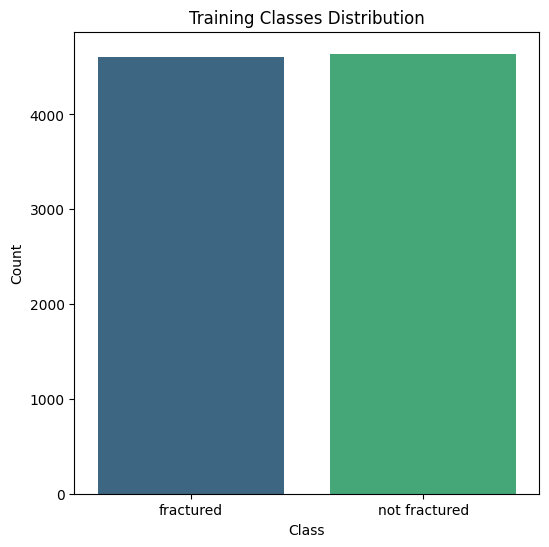

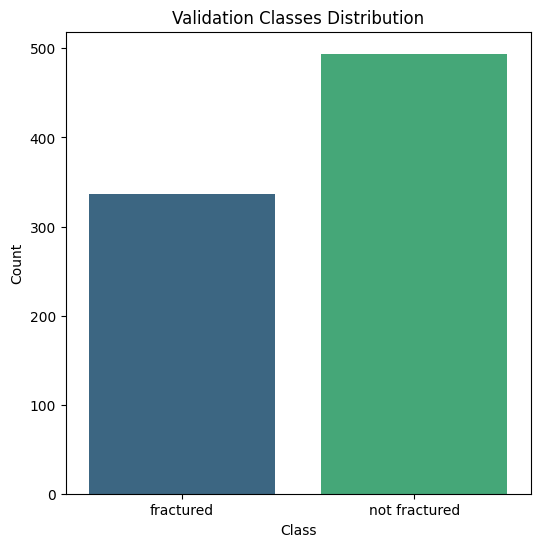

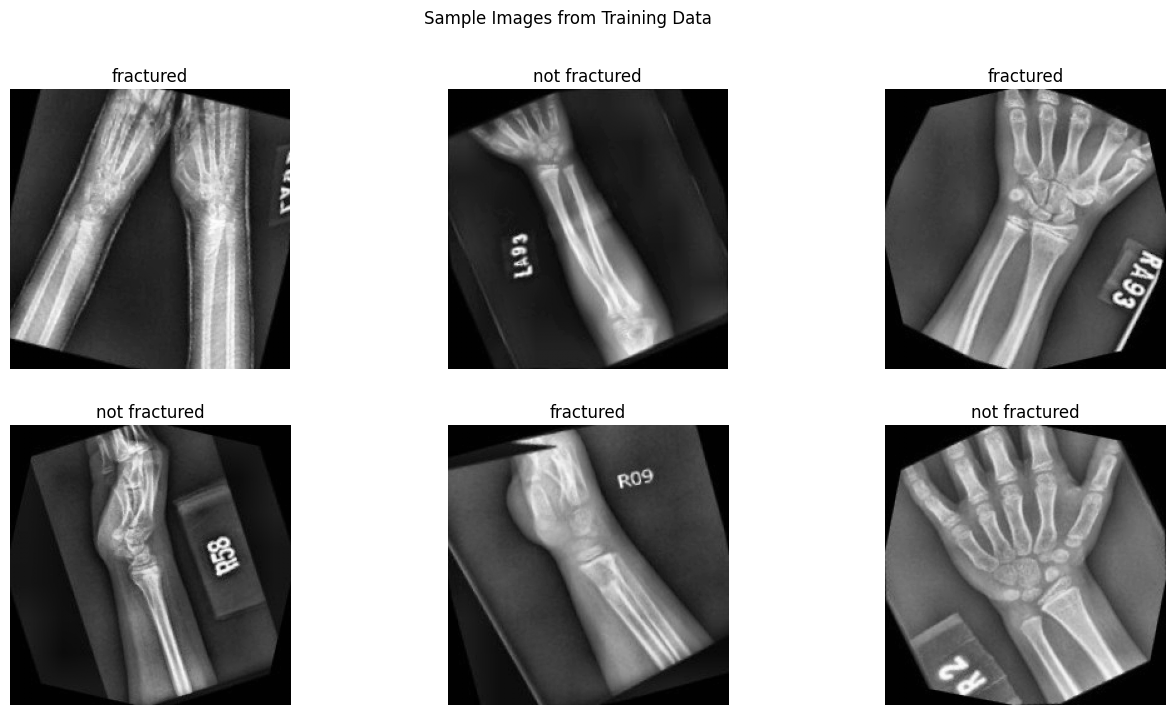

In [6]:
# --- Data Visualization (Adapted for PyTorch) ---

def plot_classes_distribution(directory, class_names, palette="viridis", title=""):
    """Counts files in subdirectories and plots class distribution."""
    counts = []
    for cls in class_names:
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            counts.append(len(os.listdir(class_path)))
        else:
            counts.append(0)

    data_counts = pd.DataFrame({'Class': class_names, 'Count': counts})
    plt.figure(figsize=(6, 6))
    sns.barplot(data=data_counts, x='Class', y='Count', palette=palette, hue='Class')
    plt.title(f"{title} Classes Distribution")
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()

def show_images_pytorch(data_loader, class_names, title):
    plt.figure(figsize=(16, 8))

    # Get one batch
    images, labels = next(iter(data_loader))

    for i in range(min(6, len(images))):
        ax = plt.subplot(2, 3, i + 1)

        # Convert from PyTorch tensor (C, H, W) to NumPy (H, W, C) for plotting
        img_np = images[i].permute(1, 2, 0).numpy()

        # Squeeze channel dim if grayscale
        if img_np.shape[2] == 1:
            img_np = np.squeeze(img_np, axis=-1)

        plt.imshow(img_np, cmap='gray')
        plt.title(class_names[labels[i].item()])
        plt.axis('off')

    plt.suptitle(title)
    plt.show()

# Visualize Distributions
plot_classes_distribution(train_dir, class_names, title="Training")
plot_classes_distribution(val_dir, class_names, title="Validation")

# Visualize Sample Images
show_images_pytorch(train_loader, class_names, title='Sample Images from Training Data')

In [7]:
# --- Model Definition (ResNet50 + Squeeze-Excitation Attention) ---

# 1. Define the Squeeze-and-Excitation (SE) Attention Block
class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block (Channel-wise Attention)
    """
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze: (b, c, h, w) -> (b, c, 1, 1)
        y = self.squeeze(x).view(b, c)
        # Excite: (b, c) -> (b, c)
        y = self.excite(y).view(b, c, 1, 1)
        # Scale (Multiply): (b, c, h, w) * (b, c, 1, 1)
        return x * y.expand_as(x)


# 2. Define the Main Model
class ResNet50WithAttention(nn.Module):
    def __init__(self, pretrained=True):
        super(ResNet50WithAttention, self).__init__()

        # 1. Load pretrained ResNet50
        weights = models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None
        self.base_model = models.resnet50(weights=weights)

        # 2. Adapt the first convolutional layer for 1-channel (grayscale) input
        original_conv1_weights = self.base_model.conv1.weight.data
        new_conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        new_conv1.weight.data = torch.mean(original_conv1_weights, dim=1, keepdim=True)
        self.base_model.conv1 = new_conv1

        # 3. Freeze the backbone
        for param in self.base_model.parameters():
            param.requires_grad = False

        # 4. Extract features from the backbone (excluding the final fc layer)
        # We will stop at the end of the convolutional layers (before avgpool)
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        # Get the number of features from the backbone
        # After layer4, ResNet50 has 2048 channels
        in_features_backbone = 2048

        # 5. NEW: Add the Attention Block
        self.attention = SEBlock(in_channels=in_features_backbone)

        # 6. Define the new classification head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), # Global Average Pooling
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features_backbone, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1) # Output for binary classification
        )

    def forward(self, x):
        # 1. Pass through the backbone
        x = self.features(x)

        # 2. Pass through the Attention Block
        x = self.attention(x)

        # 3. Pass through the classification head
        x = self.head(x)

        return x

# --- Instantiate Model and Setup ---
model = ResNet50WithAttention(pretrained=True).to(device)

# --- Setup Optimizer, Loss, Scheduler ---
# We only want to optimize the parameters that are not frozen
# (i.e., the attention block and the new head)
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=initial_learning_rate
)

# Use BCEWithLogitsLoss for binary classification (more stable than Sigmoid + BCELoss)
criterion = nn.BCEWithLogitsLoss()

# Learning rate scheduler
# --- THIS IS THE CORRECTED LINE ---
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=2, min_lr=1e-6)

# Mixed precision scaler
scaler = GradScaler()

# (Optional) Print model summary
try:
    from torchsummary import summary
    summary(model, (1, IMAGE_HEIGHT, IMAGE_WIDTH))
except ImportError:
    print("torchsummary not installed. Skipping model summary.")
    print(model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 135MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           3,136
            Conv2d-2         [-1, 64, 112, 112]           3,136
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [8]:
# --- Training and Validation Functions ---

def train_one_epoch(model, loader, criterion, optimizer, scaler, device):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    pbar = tqdm(loader, desc="Training", leave=False)
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        # Convert labels to float and add dimension for BCEWithLogitsLoss
        labels = labels.float().unsqueeze(1)

        # Mixed precision
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        preds = torch.sigmoid(outputs) > 0.5
        correct_preds += (preds == labels).sum().item()
        total_samples += labels.size(0)

        pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct_preds = 0
    total_samples = 0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Validating", leave=False)
        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            # Mixed precision (autocast is recommended for inference too)
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Statistics
            running_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            correct_preds += (preds == labels).sum().item()
            total_samples += labels.size(0)

            pbar.set_postfix(loss=loss.item())

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_preds / total_samples
    return epoch_loss, epoch_acc

In [9]:
# --- Main Training Loop ---
history = {
    'train_loss': [], 'train_acc': [],
    'val_loss': [], 'val_acc': []
}

best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 10

for epoch in range(num_epochs):
    print(f"--- Epoch {epoch+1}/{num_epochs} ---")

    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, scaler, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Reduce LR on Plateau
    scheduler.step(val_loss)

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model_with_attention.pth')
        print("Validation loss improved. Saving best model.")
    else:
        patience_counter += 1
        print(f"Validation loss did not improve. Patience: {patience_counter}/{early_stopping_patience}")

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

# Load the best model weights
print("Loading best model weights for final evaluation...")
model.load_state_dict(torch.load('best_model_with_attention.pth'))

--- Epoch 1/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 0.5582, Train Acc: 0.7557
Val Loss: 0.4752, Val Acc: 0.8375
Validation loss improved. Saving best model.
--- Epoch 2/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 0.3239, Train Acc: 0.8794
Val Loss: 0.4863, Val Acc: 0.8929
Validation loss did not improve. Patience: 1/5
--- Epoch 3/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bfc073358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1647, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7bfc073358a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1664, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

Train Loss: 0.2220, Train Acc: 0.9212
Val Loss: 0.7886, Val Acc: 0.9122
Validation loss did not improve. Patience: 2/5
--- Epoch 4/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 0.1649, Train Acc: 0.9413
Val Loss: 1.4601, Val Acc: 0.9242
Validation loss did not improve. Patience: 3/5
--- Epoch 5/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 0.1331, Train Acc: 0.9547
Val Loss: 1.7558, Val Acc: 0.9266
Validation loss did not improve. Patience: 4/5
--- Epoch 6/30 ---


Training:   0%|          | 0/289 [00:00<?, ?it/s]

Validating:   0%|          | 0/26 [00:00<?, ?it/s]

Train Loss: 0.1241, Train Acc: 0.9588
Val Loss: 2.0037, Val Acc: 0.9350
Validation loss did not improve. Patience: 5/5
Early stopping triggered.
Loading best model weights for final evaluation...


<All keys matched successfully>

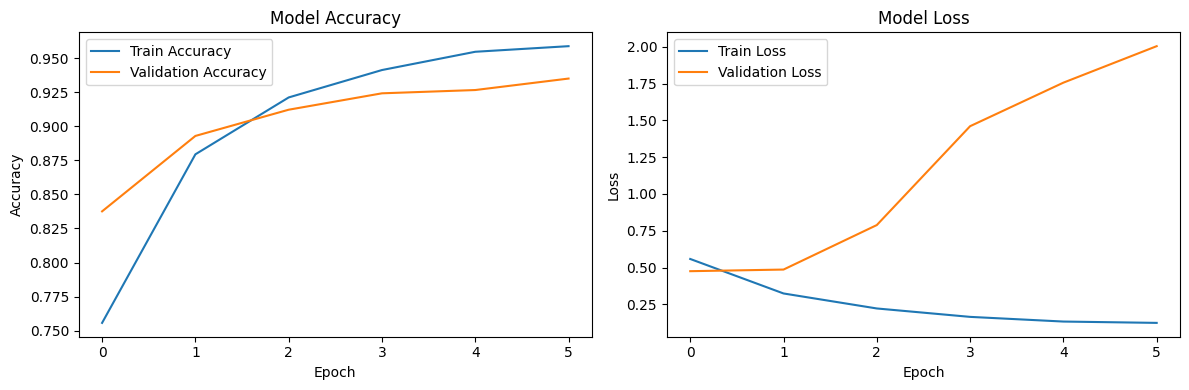

In [10]:
# --- Plot Training History ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
ax[0].plot(history['train_acc'], label='Train Accuracy')
ax[0].plot(history['val_acc'], label='Validation Accuracy')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend()

# Plot Loss
ax[1].plot(history['train_loss'], label='Train Loss')
ax[1].plot(history['val_loss'], label='Validation Loss')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

plt.tight_layout()
plt.show()

Evaluating on Test Set...


Validating:   0%|          | 0/16 [00:00<?, ?it/s]

Test Loss: 0.5811, Test Accuracy: 0.7905

Classification Report:

               precision    recall  f1-score   support

    fractured       0.73      0.89      0.80       238
not fractured       0.88      0.70      0.78       268

     accuracy                           0.79       506
    macro avg       0.80      0.80      0.79       506
 weighted avg       0.81      0.79      0.79       506



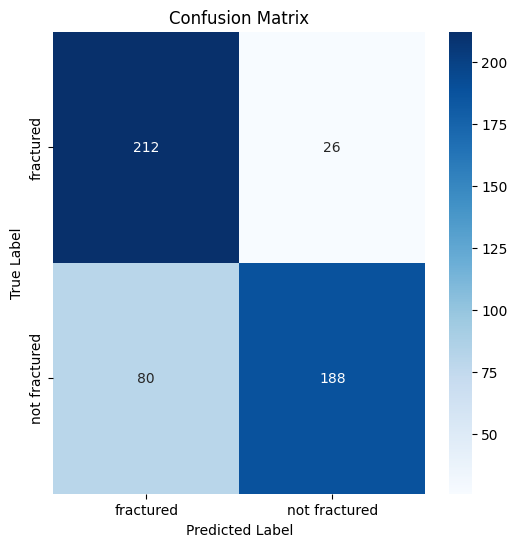

In [11]:
# --- Evaluation on Test Set ---
print("Evaluating on Test Set...")
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Get Predictions for Classification Report
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)

        with autocast():
            outputs = model(inputs)

        preds = torch.sigmoid(outputs) > 0.5

        all_labels.extend(labels.numpy())
        all_preds.extend(preds.cpu().numpy().flatten())

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Running Fixed Grad-CAM Visualization...

=== Analyzing Image 0 (Grad-CAM) ===
Error during Grad-CAM visualization: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.

=== Analyzing Image 238 (Grad-CAM) ===
Error during Grad-CAM visualization: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.

Visualizing SE Attention Weights...

=== Analyzing Image 0 (SE Attention) ===


Traceback (most recent call last):
  File "/tmp/ipython-input-150613748.py", line 140, in visualize_grad_cam_fixed
    grad_cam = GradCAMFixed(model, target_layer)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-150613748.py", line 25, in __init__
    self.target_layer.register_full_backward_hook(self._backward_hook)
  File "/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py", line 1499, in register_full_backward_hook
    raise RuntimeError(
RuntimeError: Cannot use both regular backward hooks and full backward hooks on a single Module. Please use only one of them.
Traceback (most recent call last):
  File "/tmp/ipython-input-150613748.py", line 140, in visualize_grad_cam_fixed
    grad_cam = GradCAMFixed(model, target_layer)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-150613748.py", line 25, in __init__
    self.target_layer.register_full_backward_hook(self._backward_hook)
  File "/usr/local/lib/python3.12/dis

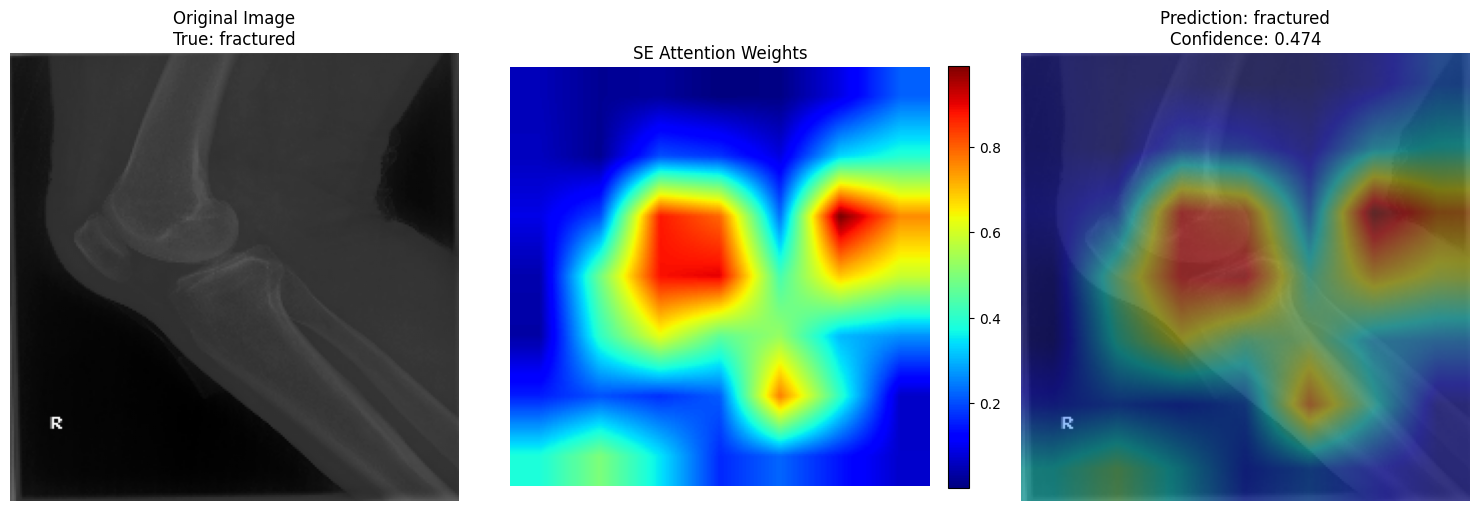


=== Analyzing Image 238 (SE Attention) ===


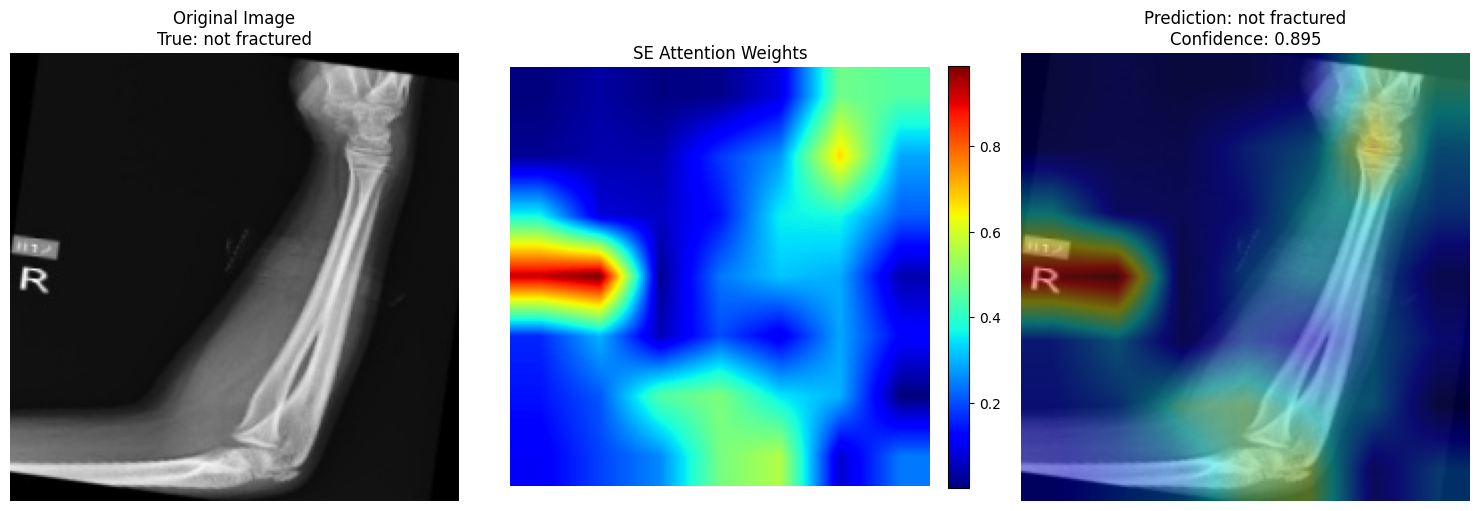

In [22]:
# --- Fixed Grad-CAM++ Implementation for Frozen Backbones ---

class GradCAMFixed:
    """
    Enhanced PyTorch implementation of Grad-CAM++ with robust error handling
    and better support for frozen backbones.
    """
    def __init__(self, model, target_layer):
        """
        Args:
            model: The PyTorch model
            target_layer: The layer to extract features from (e.g., model.features[-1][-1])
        """
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hooks = []

        # Register hooks
        self.hooks.append(
            self.target_layer.register_forward_hook(self._forward_hook)
        )
        self.hooks.append(
            self.target_layer.register_full_backward_hook(self._backward_hook)
        )

    def _forward_hook(self, module, input, output):
        """Capture activations from forward pass"""
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        """Capture gradients from backward pass"""
        # grad_output[0] contains gradients w.r.t. the output of this layer
        if grad_output[0] is not None:
            self.gradients = grad_output[0].detach()

    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

    def generate_heatmap(self, input_tensor, class_idx=0):
        """
        Generate Grad-CAM++ heatmap

        Args:
            input_tensor: Input image tensor (B, C, H, W)
            class_idx: Target class index (0 for binary classification)

        Returns:
            heatmap: Normalized heatmap as numpy array (H, W)
        """
        self.model.eval()

        # Ensure input requires gradient
        input_tensor = input_tensor.requires_grad_(True)

        # Forward pass
        output = self.model(input_tensor)

        # Zero all gradients
        self.model.zero_grad()
        if input_tensor.grad is not None:
            input_tensor.grad.zero_()

        # Backward pass
        score = output[:, class_idx]
        score.backward()

        # Check if we captured gradients and activations
        if self.gradients is None:
            raise RuntimeError(
                "Failed to capture gradients. This usually means:\n"
                "1. The target layer has no trainable parameters\n"
                "2. The backward pass didn't reach the target layer\n"
                "Try selecting a different target layer or unfreezing some layers."
            )

        if self.activations is None:
            raise RuntimeError("Failed to capture activations from forward pass.")

        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations

        # --- Grad-CAM++ calculations ---
        # Compute alpha weights
        grads_power_2 = gradients ** 2
        grads_power_3 = grads_power_2 * gradients

        # Sum over spatial dimensions
        sum_activations = torch.sum(activations * grads_power_3, dim=(2, 3), keepdim=True)

        alpha_num = grads_power_2
        alpha_denom = 2.0 * grads_power_2 + sum_activations
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num / alpha_denom

        # Compute weights
        weights = torch.sum(alpha * torch.relu(gradients), dim=(2, 3), keepdim=True)

        # Generate heatmap
        heatmap = torch.sum(weights * activations, dim=1).squeeze()

        # Apply ReLU to the heatmap
        heatmap = torch.relu(heatmap)

        # Normalize to [0, 1]
        heatmap_min = torch.min(heatmap)
        heatmap_max = torch.max(heatmap)

        if heatmap_max - heatmap_min > 1e-10:
            heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)
        else:
            # If heatmap is uniform, return zeros
            heatmap = torch.zeros_like(heatmap)

        return heatmap.cpu().numpy()


def visualize_grad_cam_fixed(model, target_layer, img_tensor, original_img_np,
                              true_label_idx, class_names):
    """
    Visualizes Grad-CAM++ heatmap with improved error handling

    Args:
        model: PyTorch model
        target_layer: Layer to visualize (e.g., model.features[-1][-1])
        img_tensor: Preprocessed image tensor (1, C, H, W) on device
        original_img_np: Original image as numpy array (H, W)
        true_label_idx: Ground truth label index
        class_names: List of class names
    """
    grad_cam = None
    try:
        # 1. Initialize Grad-CAM
        grad_cam = GradCAMFixed(model, target_layer)

        # 2. Generate heatmap
        heatmap = grad_cam.generate_heatmap(img_tensor, class_idx=0)

        # 3. Prepare original image
        if len(original_img_np.shape) > 2:
            original_img_np = np.squeeze(original_img_np)

        # Convert to uint8 if needed
        if original_img_np.max() <= 1.0:
            original_img_uint8 = (original_img_np * 255).astype(np.uint8)
        else:
            original_img_uint8 = original_img_np.astype(np.uint8)

        # 4. Resize heatmap to match original image
        if heatmap.size > 0:
            heatmap_resized = cv2.resize(
                heatmap,
                (original_img_uint8.shape[1], original_img_uint8.shape[0]),
                interpolation=cv2.INTER_LINEAR
            )
        else:
            # Fallback: create empty heatmap
            heatmap_resized = np.zeros(
                (original_img_uint8.shape[0], original_img_uint8.shape[1])
            )

        # 5. Apply colormap
        heatmap_uint8 = (heatmap_resized * 255).astype(np.uint8)
        heatmap_color = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

        # 6. Convert grayscale to BGR for overlay
        original_img_color = cv2.cvtColor(original_img_uint8, cv2.COLOR_GRAY2BGR)

        # 7. Superimpose heatmap
        superimposed_img = cv2.addWeighted(original_img_color, 0.6, heatmap_color, 0.4, 0)

        # 8. Get prediction
        with torch.no_grad():
            output = model(img_tensor)
            pred_score = torch.sigmoid(output).item()

        pred_class_idx = int(pred_score > 0.5)

        # 9. Plot results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(original_img_uint8, cmap='gray')
        plt.title(f"Original Image\nTrue: {class_names[true_label_idx]}", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap_resized, cmap='jet')
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title("Grad-CAM++ Heatmap", fontsize=12)
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
        plt.title(f"Prediction: {class_names[pred_class_idx]}\nConfidence: {pred_score:.3f}",
                  fontsize=12)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error during Grad-CAM visualization: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Always remove hooks
        if grad_cam is not None:
            grad_cam.remove_hooks()


# --- Alternative: Use the attention layer itself ---
def visualize_attention_weights(model, img_tensor, original_img_np,
                                true_label_idx, class_names):
    """
    Alternative visualization: Show the attention weights directly
    This works even when the backbone is frozen
    """
    model.eval()

    # Hook to capture attention output
    attention_output = None

    def attention_hook(module, input, output):
        nonlocal attention_output
        attention_output = output.detach()

    # Register hook on attention layer
    hook = model.attention.register_forward_hook(attention_hook)

    try:
        # Forward pass
        with torch.no_grad():
            output = model(img_tensor)
            pred_score = torch.sigmoid(output).item()

        pred_class_idx = int(pred_score > 0.5)

        # Get attention weights
        if attention_output is not None:
            # Average across channels to get spatial attention map
            attention_map = torch.mean(attention_output, dim=1).squeeze().cpu().numpy()

            # Normalize
            attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-10)

            # Prepare original image
            if len(original_img_np.shape) > 2:
                original_img_np = np.squeeze(original_img_np)

            if original_img_np.max() <= 1.0:
                original_img_uint8 = (original_img_np * 255).astype(np.uint8)
            else:
                original_img_uint8 = original_img_np.astype(np.uint8)

            # Resize attention map
            attention_resized = cv2.resize(
                attention_map,
                (original_img_uint8.shape[1], original_img_uint8.shape[0]),
                interpolation=cv2.INTER_LINEAR
            )

            # Apply colormap
            attention_uint8 = (attention_resized * 255).astype(np.uint8)
            attention_color = cv2.applyColorMap(attention_uint8, cv2.COLORMAP_JET)

            # Overlay
            original_img_color = cv2.cvtColor(original_img_uint8, cv2.COLOR_GRAY2BGR)
            overlay = cv2.addWeighted(original_img_color, 0.6, attention_color, 0.4, 0)

            # Plot
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.imshow(original_img_uint8, cmap='gray')
            plt.title(f"Original Image\nTrue: {class_names[true_label_idx]}", fontsize=12)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(attention_resized, cmap='jet')
            plt.colorbar(fraction=0.046, pad=0.04)
            plt.title("SE Attention Weights", fontsize=12)
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
            plt.title(f"Prediction: {class_names[pred_class_idx]}\nConfidence: {pred_score:.3f}",
                      fontsize=12)
            plt.axis('off')

            plt.tight_layout()
            plt.show()

    finally:
        hook.remove()


# --- Usage Example ---
# Replace the existing visualization code with:

print("Running Fixed Grad-CAM Visualization...")

# Option 1: Try Grad-CAM on the last layer before attention
target_layer = model.features[-1][-1]  # Last bottleneck block

for img_idx in samples_to_viz[:2]:  # Visualize first 2 samples
    tensor_img, true_label = test_dataset[img_idx]

    path, _ = raw_test_dataset.samples[img_idx]
    raw_img_np = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw_img_np_resized = cv2.resize(raw_img_np, img_size)

    tensor_img_batch = tensor_img.unsqueeze(0).to(device)

    print(f"\n=== Analyzing Image {img_idx} (Grad-CAM) ===")
    visualize_grad_cam_fixed(
        model,
        target_layer,
        tensor_img_batch,
        raw_img_np_resized,
        true_label,
        class_names
    )

# Option 2: Visualize SE attention weights directly
print("\n" + "="*50)
print("Visualizing SE Attention Weights...")
print("="*50)

for img_idx in samples_to_viz[:2]:
    tensor_img, true_label = test_dataset[img_idx]

    path, _ = raw_test_dataset.samples[img_idx]
    raw_img_np = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    raw_img_np_resized = cv2.resize(raw_img_np, img_size)

    tensor_img_batch = tensor_img.unsqueeze(0).to(device)

    print(f"\n=== Analyzing Image {img_idx} (SE Attention) ===")
    visualize_attention_weights(
        model,
        tensor_img_batch,
        raw_img_np_resized,
        true_label,
        class_names
    )

In [23]:
# --- Save Model and Grad-CAM for Implementation (PyTorch) ---

# 1. Save the best model's state dictionary
final_model_path = 'bone_fracture_model_attention_pytorch.pth'
torch.save(model.state_dict(), final_model_path)
print(f"Final model state dictionary saved to: {final_model_path}")

# 2. Write the inference_utils_pytorch.py script
# IMPORTANT: This script MUST contain the model class definitions
# (SEBlock and ResNet50WithAttention) to work.

Final model state dictionary saved to: bone_fracture_model_attention_pytorch.pth


In [24]:
%%writefile inference_utils_pytorch.py
import cv2
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
from PIL import Image

# --- 1. Model Definitions (Must match training) ---
# These are required to reconstruct the model before loading weights

class SEBlock(nn.Module):
    """
    Squeeze-and-Excitation Block (Channel-wise Attention)
    """
    def __init__(self, in_channels, reduction_ratio=16):
        super(SEBlock, self).__init__()
        self.squeeze = nn.AdaptiveAvgPool2d(1)
        self.excite = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.squeeze(x).view(b, c)
        y = self.excite(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class ResNet50WithAttention(nn.Module):
    def __init__(self, pretrained=False): # Set pretrained=False for inference
        super(ResNet50WithAttention, self).__init__()

        self.base_model = models.resnet50(weights=None) # No weights

        # Adapt conv1 for 1 channel
        self.base_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

        # Extract features
        self.features = nn.Sequential(*list(self.base_model.children())[:-2])

        in_features_backbone = 2048

        # Add Attention Block
        self.attention = SEBlock(in_channels=in_features_backbone)

        # Add classification head
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(in_features_backbone, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.attention(x)
        x = self.head(x)
        return x

# --- 2. Preprocessing Function (Must match training) ---
def preprocess_cv2_inference(img_np):
    """
    Applies CLAHE and normalization to a NumPy array.
    Input is a 2D grayscale image (H, W).
    """
    if img_np.dtype != np.uint8:
        img_np = img_np.astype(np.uint8)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img_np = clahe.apply(img_np)

    img_min = img_np.min()
    img_max = img_np.max()
    img_range = img_max - img_min
    if img_range == 0:
        img_range = 1e-6
    img_np = (img_np.astype(np.float32) - img_min) / img_range
    img_np = np.expand_dims(img_np, axis=-1)

    # Convert from (H, W, C) numpy to (C, H, W) tensor
    return torch.from_numpy(img_np).permute(2, 0, 1)

# --- 3. Grad-CAM++ Core Class ---
class GradCAM:
    """
    Grad-CAM++ implementation with two-hook fix for frozen backbones.
    """
    def __init__(self, model, target_feature_layer, target_gradient_module):
        self.model = model
        self.target_feature_layer = target_feature_layer
        self.target_gradient_module = target_gradient_module
        self.gradients = None
        self.activations = None

        self.hook_handle_f = self.target_feature_layer.register_forward_hook(self._forward_hook)
        self.hook_handle_b = self.target_gradient_module.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_in, grad_out):
        if grad_in[0] is not None:
            self.gradients = grad_in[0]

    def remove_hooks(self):
        self.hook_handle_f.remove()
        self.hook_handle_b.remove()

    def generate_heatmap(self, input_tensor):
        self.model.eval()

        # --- FIX: Force the input to the gradient module to require grads ---
        def set_requires_grad_hook(module, input):
            input[0].requires_grad_(True)
        pre_hook_handle = self.target_gradient_module.register_forward_pre_hook(set_requires_grad_hook)
        # --- End Fix ---

        # 1. Forward pass
        output = self.model(input_tensor) # Triggers forward_hook and pre_hook
        pre_hook_handle.remove()

        # 2. Zero gradients
        self.model.zero_grad()

        # 3. Backward pass
        target = output[:, 0]
        target.backward() # Triggers backward_hook

        if self.gradients is None or self.activations is None:
            self.remove_hooks()
            raise RuntimeError("Failed to capture gradients or activations.")

        gradients = self.gradients.cpu().data
        activations = self.activations.cpu().data

        if gradients.shape != activations.shape:
             gradients = torch.nn.functional.adaptive_avg_pool2d(gradients, activations.shape[2:])

        grads_power_2 = gradients**2
        grads_power_3 = grads_power_2 * gradients

        alpha_num = grads_power_2
        alpha_den = 2.0 * grads_power_2 + torch.sum(activations * grads_power_3, dim=(2, 3), keepdim=True)
        alpha_den = torch.where(alpha_den == 0.0, 1e-10, alpha_den)
        alpha = alpha_num / alpha_den

        weights = torch.sum(alpha * torch.relu(gradients), dim=(2, 3), keepdim=True)
        heatmap = torch.sum(weights * activations, dim=1).squeeze(0)
        heatmap = torch.relu(heatmap)

        heatmap -= torch.min(heatmap)
        heatmap /= (torch.max(heatmap) + 1e-10)

        return heatmap.numpy()

# --- 4. Superimposing Helper Function ---
def create_superimposed_image(original_img_gray, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    Overlays a heatmap on the original grayscale image.
    original_img_gray: 2D numpy array (H, W) in 0-255 range
    heatmap: 2D numpy array (H, W) in 0-1 range
    """
    heatmap_resized = cv2.resize(heatmap, (original_img_gray.shape[1], original_img_gray.shape[0]))
    heatmap_uint8 = (heatmap_resized * 255).astype(np.uint8)
    heatmap_color = cv2.applyColorMap(heatmap_uint8, colormap)

    if original_img_gray.dtype != np.uint8:
        original_img_gray = original_img_gray.astype(np.uint8)

    original_img_color = cv2.cvtColor(original_img_gray, cv2.COLOR_GRAY2BGR)
    superimposed_img = cv2.addWeighted(original_img_color, 1 - alpha, heatmap_color, alpha, 0)
    return superimposed_img

# --- 5. Main Inference Function ---
def run_inference_and_gradcam_pytorch(model, image_path, img_size=(224, 224),
                                      feature_layer_name='features.7.2',
                                      gradient_module_name='attention',
                                      class_names=['not_fractured', 'fractured']):
    """
    Loads an image, runs inference, and generates Grad-CAM.

    Returns:
    - prediction_label (str): The predicted class name.
    - confidence (float): The model's confidence (0.0 to 1.0).
    - superimposed_image (np.array): The original image with Grad-CAM overlay.
    """
    grad_cam = None
    try:
        # 1. Load and Resize Image
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Could not read image from {image_path}")
        img_resized = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)

        # 2. Preprocess Image and create batch
        img_tensor = preprocess_cv2_inference(img_resized)
        img_batch = img_tensor.unsqueeze(0) # Add batch dimension

        # 3. Get target layers from model
        all_modules = dict(model.named_modules())
        try:
            target_feature_layer = all_modules[feature_layer_name]
            target_gradient_module = all_modules[gradient_module_name]
        except KeyError as e:
            raise ValueError(f"Target layer not found. {e}. Check layer names.")

        # 4. Setup Grad-CAM
        grad_cam = GradCAM(model, target_feature_layer, target_gradient_module)

        # 5. Run Prediction (on CPU)
        model.eval()
        with torch.no_grad():
            output = model(img_batch)
            confidence = torch.sigmoid(output).item()

        pred_class_idx = int(confidence > 0.5)
        prediction_label = class_names[pred_class_idx]

        # 6. Generate Grad-CAM (requires gradients, so no torch.no_grad())
        heatmap = grad_cam.generate_heatmap(img_batch)

        # 7. Create Superimposed Image
        superimposed_image = create_superimposed_image(img_resized, heatmap)

        return prediction_label, float(confidence), superimposed_image

    except Exception as e:
        print(f"Error during inference: {e}")
        return None, None, None
    finally:
        # CRITICAL: Always remove hooks
        if grad_cam:
            grad_cam.remove_hooks()

print("Saved inference_utils_pytorch.py")

Writing inference_utils_pytorch.py


In [25]:
# --- Example: How to use the saved script ---

# 1. Import necessary libraries
# We must import the model classes from the file
from inference_utils_pytorch import ResNet50WithAttention, run_inference_and_gradcam_pytorch
import torch
import cv2
import matplotlib.pyplot as plt

# 2. Define model path and class names
MODEL_PATH = 'bone_fracture_model_attention_pytorch.pth'
CLASS_NAMES = ['not_fractured', 'fractured']
# This name 'features.7.2' corresponds to 'model.features[-1][-1]'
# It's the last Bottleneck block in layer4
TARGET_LAYER_NAME = 'features.7.2'

# 3. Instantiate model and load weights
inference_model = ResNet50WithAttention(pretrained=False)
inference_model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device('cpu'))) # Load to CPU
inference_model.eval()
print("PyTorch model with Attention loaded for inference.")

# 4. Get a sample image path from our test set
try:
    path_to_test_image, _ = test_dataset.samples[0]
    print(f"Running inference on: {path_to_test_image}")

    # 5. Run inference
    label, confidence, grad_cam_image = run_inference_and_gradcam_pytorch(
        inference_model,
        path_to_test_image,
        layer_name=TARGET_LAYER_NAME,
        class_names=CLASS_NAMES
    )

    # 6. Display results
    if label is not None:
        print(f"\nPrediction: {label}")
        print(f"Confidence: {confidence:.4f}")

        # Display image with Grad-CAM
        plt.imshow(cv2.cvtColor(grad_cam_image, cv2.COLOR_BGR2RGB))
        plt.title("Inference Result with Grad-CAM")
        plt.axis('off')
        plt.show()

except Exception as e:
    print(f"Could not run test inference: {e}")

Saved inference_utils_pytorch.py
PyTorch model with Attention loaded for inference.
Running inference on: /content/drive/MyDrive/Bone/test/fractured/001.png
Could not run test inference: run_inference_and_gradcam_pytorch() got an unexpected keyword argument 'layer_name'
